In [1]:
#
# Load the wingshape and the known cutting pattern
#

import sys
sys.path.append("/home/julian/repositories")

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [2]:
#
# Derive the polygons from the network of nodes in UV space ( --> XYZ space by function wingshape.seval )
#
from barmesh.basicgeo import I1, Partition1, P2

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes, bclosed=True)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "plcentre":sum(polyloop, start=P2(0,0))*(1.0/len(polyloop)), 
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [3]:
#
# We need to identify and number the polygons (and some of the edges) appropriately 
# So that we can make the differential offsetting of them
#

#surfacemeshes.sort(key=lambda x: -x["plcentre"].v + x["plcentre"].u*0.05)
#print("{%s}" % ",\n\t".join("'s%d':%s" % (i, "(%.3f, %.3f)" % surfacemesh["plcentre"])  for i, surfacemesh in enumerate(surfacemeshes) ))

patchnamelookups = {   
    'US1':(0.851, 0.865),
    'US2':(3.907, 0.864),
    'LEI1':(0.207, 0.106),
    'LEI2':(0.622, 0.106),
    'LEI3':(1.045, 0.106),
    'LEI4':(1.481, 0.106),
    'LEI5':(2.158, 0.106),
    'LEI6':(3.484, 0.106),
    'LEI7':(4.734, 0.106),
    'LEI8':(5.612, 0.106),
    'TSF1':(0.851, -0.294),
    'TSF2':(3.907, -0.294),
    'TSM1':(0.415, -0.913),
    'TSM2':(1.266, -0.913),
    'TSM3':(3.394, -0.827),
    'TSR':(4.082, -1.073) }

for surfacemesh in surfacemeshes:
    surfacemesh["patchname"] = min(((surfacemesh["plcentre"] - P2(*p)).Len(), name)  for name, p in patchnamelookups.items())[1]
assert len(set(surfacemesh["patchname"]  for surfacemesh in surfacemeshes)) == len(patchnamelookups)
surfacemeshesdict = dict((surfacemesh["patchname"], surfacemesh)  for surfacemesh in surfacemeshes)

In [4]:
#
# Calculate the offsets of the polygons based on a common rectangular subdivision spacing xpartA, xpartB
# and product a contour in UV space that would project to the offset 3D surface
#

radoffset = 0.006
uspacing, vspacing = 0.02, 0.02

battonuvlines = [ ]
for u in wingshape.leadingedgelengths[1:-1]:
    battonuvlines.append([P2(u, v)  for v in numpy.arange(wingshape.vrange[0]-vspacing, wingshape.vrange[1]+vspacing, vspacing)])

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour
#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1

urgA, vrgA = I1(*wingshape.urange).Inflate(0.06), I1(*wingshape.vrange).Inflate(0.06)
xpartA = Partition1(urgA.lo, urgA.hi, int(urgA.Leng()/uspacing + 2))
ypartA = Partition1(vrgA.lo, vrgA.hi, int(vrgA.Leng()/vspacing + 2))

def SubPartition(part, vlo, vhi):
    res = Partition1(0, 1, 2)
    ilo, ihi = part.GetPartRange(vlo, vhi)
    res.vs = part.vs[ilo:ihi+2]
    res.lo, res.hi = res.vs[0], res.vs[-1]
    res.nparts = ihi - ilo + 1
    assert len(res.vs) == res.nparts + 1
    assert res.lo < vlo < vhi < res.hi, (res.lo , vlo , vhi , res.hi)
    return res

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = SubPartition(xpartA, urg.lo, urg.hi)
    ypart = SubPartition(ypartA, vrg.lo, vrg.hi)

    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop)
    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()

    surfacemesh["barmeshoffset"] = bm
    surfacemesh["xpart"] = xpart
    surfacemesh["ypart"] = ypart

    nxs = xpart.nparts + 1
    for iy in range(ypart.nparts + 1):
        for ix in range(nxs):
            assert bm.nodes[iy*nxs + ix].sp == P2(xpart.vs[ix], ypart.vs[iy])
    


Starting 0
make triangle boxing at 0.047043302883781335
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 3040 nodes
do splitbarsdirectionchangesR on 5953 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  228
nsegs: 252 bad: 0 working: 0
116 [20, 25, 20, 5, 15, 15, 3, 5, 0, 8, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.04245011031816404
make triangle boxing at 0.06165027625633657
MakePointZoneRFS done on 5016 nodes
do splitbarsdirectionchangesR on 9782 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  478
nsegs: 490 bad: 0 working: 0
58 [15, 5, 10, 0, 13, 0, 5, 0, 10, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.052358552582613564
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 1664 nodes
do splitbarsdirectionchangesR on 3244 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  142
nsegs: 165 bad: 0 working: 0
109 [10, 10, 20, 5, 8, 3, 25, 5, 8, 5, 5, 5, 0, 0, 0, 0, 0]

Starting 3
make tri

In [5]:
#
# Find and triangulate all the cpolys (polygons in the uvcells) per offsetmesh
#

from barmesh import barmesh
from wingflatten_barmeshfuncs import findallnodesandpolys, cpolytriangulate

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    xpart = surfacemesh["xpart"]
    ypart = surfacemesh["ypart"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    surfacemesh["offsettopbar"] = topbars[0]
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]
    tnodes, cpolys = findallnodesandpolys(bm)
    ptsF = [ node.sp  for node in tnodes ]
    surfacemesh["pts"] = numpy.array([ node.p  for node in tnodes ])
    surfacemesh["uvpts"] = uvpts = numpy.array(ptsF)
    tris = [ ]
    for cpoly in cpolys:
        tris.extend(cpolytriangulate(ptsF, cpoly))

    surfacemesh["tris"] = numpy.array(tris)
    surfacemesh["offsetloopI"] = [n.i for n in outercont]
    print(surfacemesh["patchname"], "points", len(ptsF), "triangles", len(tris))


LEI6 points 2499 triangles 4744
TSF2 points 4076 triangles 7660
LEI5 points 1335 triangles 2503
US2 points 12347 triangles 24126
LEI7 points 1145 triangles 2138
TSM3 points 7080 triangles 13716
TSR points 4921 triangles 9148
LEI4 points 712 triangles 1304
LEI8 points 1513 triangles 2851
US1 points 4874 triangles 9449
LEI1 points 678 triangles 1243
LEI2 points 679 triangles 1243
TSF1 points 1611 triangles 3000
LEI3 points 678 triangles 1241
TSM2 points 2334 triangles 4463
TSM1 points 2276 triangles 4353


In [6]:
#
# Call the surface flattener (produces surfacemesh["fpts"], "triareas", "ftriareas")
#

#freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "freecad"   # nixos install

from parapolygraph import trimeshesflattener
trimeshesflattener(surfacemeshes, freecadappimage)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=2499, tris=4744) flattened
mesh (pts=4076, tris=7660) flattened
mesh (pts=1335, tris=2503) flattened
mesh (pts=12347, tris=24126) flattened
mesh (pts=1145, tris=2138) flattened
mesh (pts=7080, tris=13716) flattened
mesh (pts=4921, tris=9148) flattened
mesh (pts=712, tris=1304) flattened
mesh (pts=1513, tris=2851) flattened
mesh (pts=4874, tris=9449) flattened
mesh (pts=678, tris=1243) flattened
mesh (pts=679, tris=1243) flattened
mesh (pts=1611, tris=3000) flattened
mesh (pts=678, tris=1241) flattened
mesh (pts=2334, tris=4463) flattened
mesh (pts=2276, tris=4353) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



In [7]:
#
# Rotate and move the flat pieces produce the exploded diagram
#
from wingflatten_barmeshfuncs import applyconsistenrotationtoflats

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    applyconsistenrotationtoflats(surfacemesh)

<IPython.core.display.Javascript object>


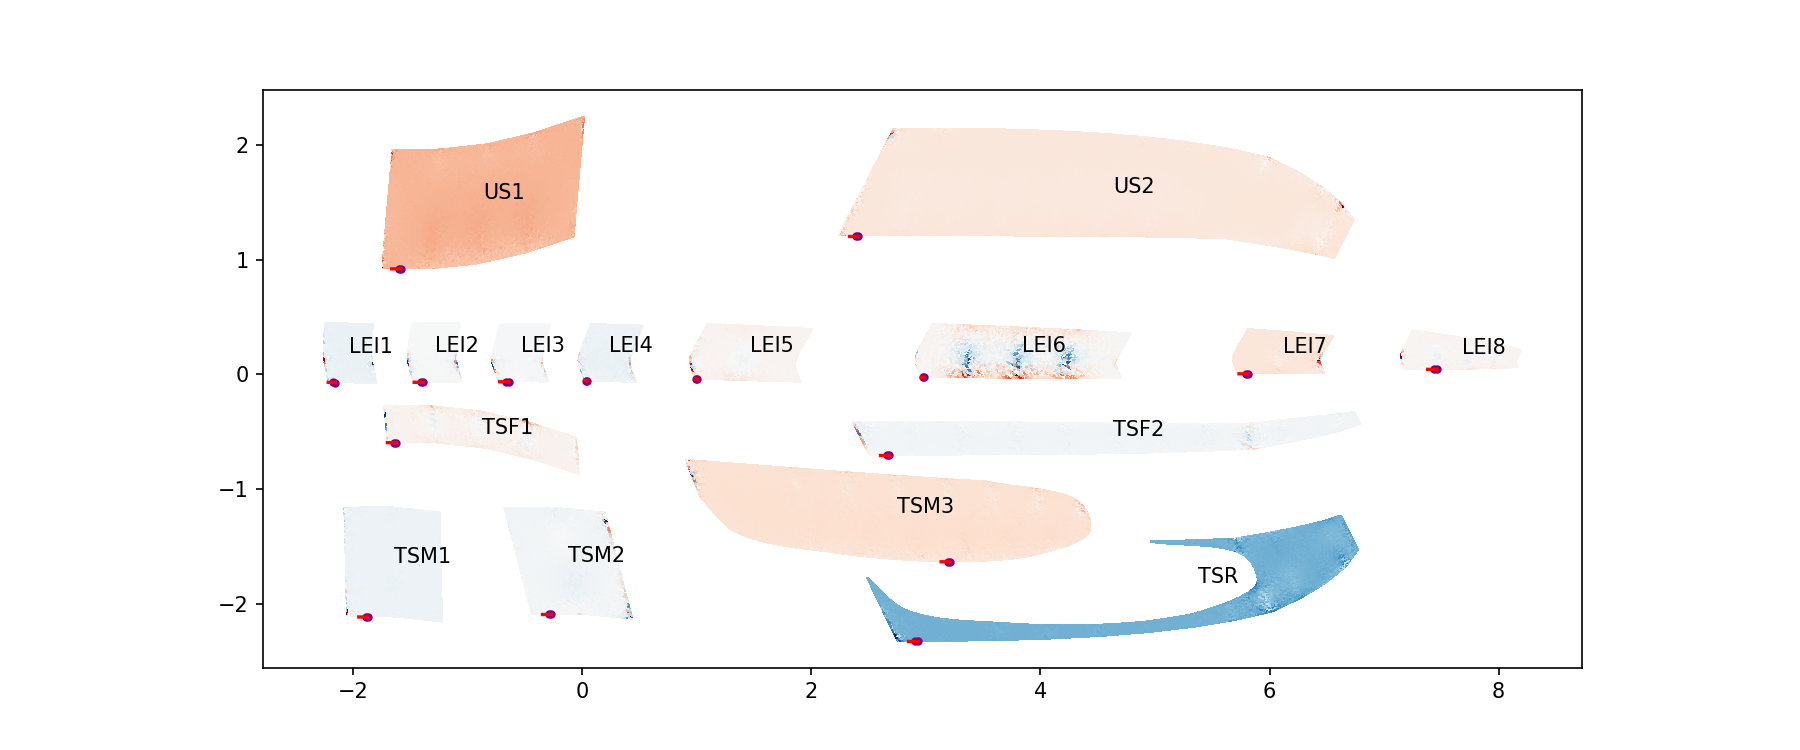

In [8]:
# 
# Exploded diagram of the flattened pieces
# 

%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["fptsT"]
    #fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange, cmap='RdBu')

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[-10:-5,0], contour[-10:-5,1], color="red", linewidth=1.6)
    plt.scatter(contour[-10:-8,0], contour[-10:-8,1], color="purple", marker=".")

plt.gca().autoscale()
plt.gca().set_aspect("equal")
#plt.colorbar()


<IPython.core.display.Javascript object>


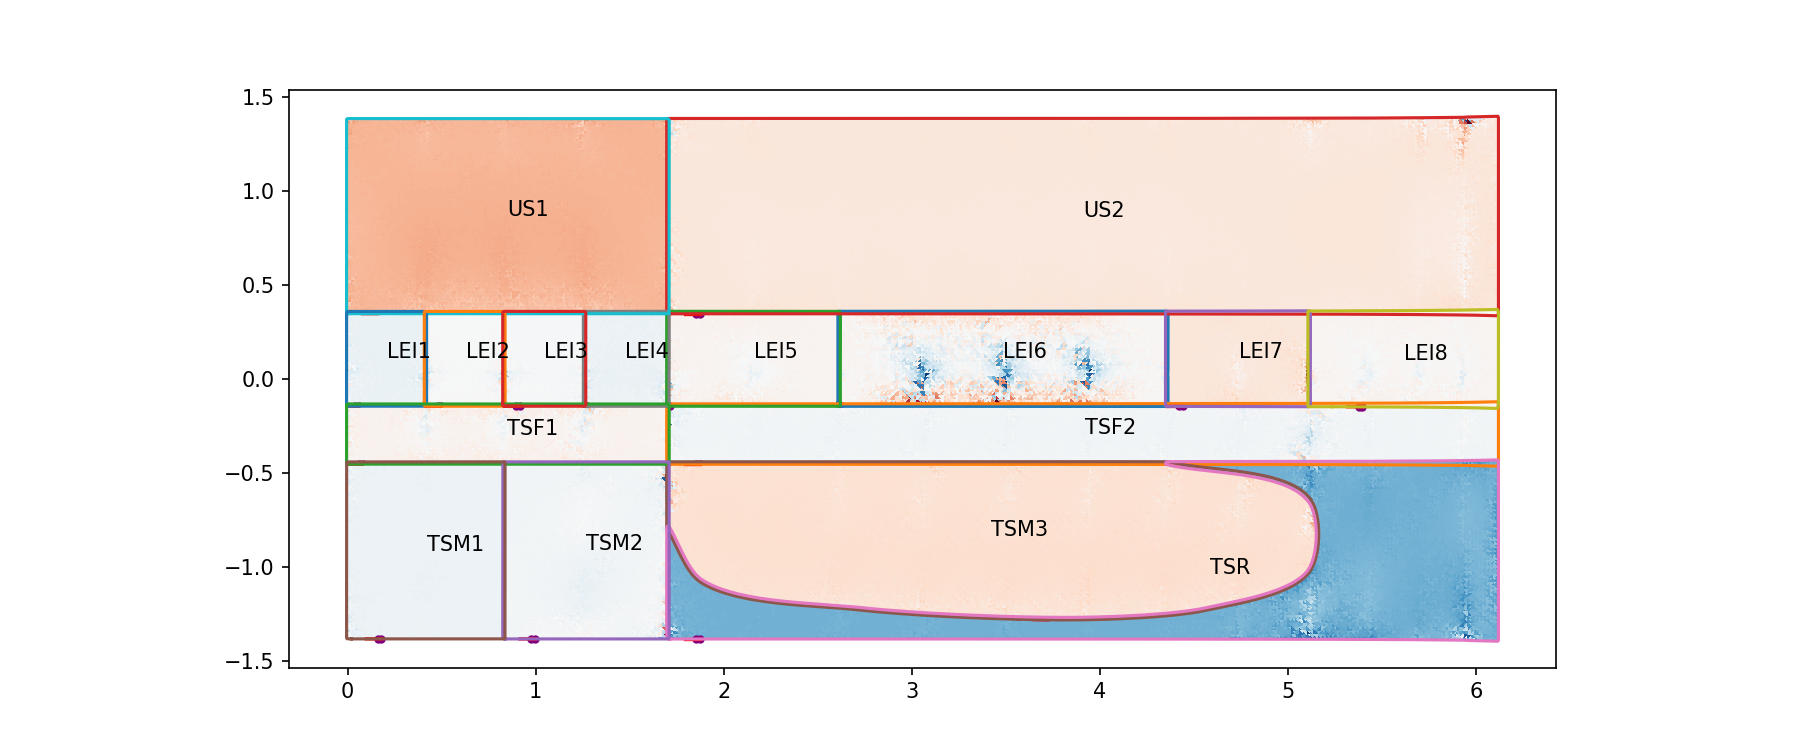

LEI6 areachange ratios 0.9995975200608317 1.0004096975496004
TSF2 areachange ratios 0.9988809224650657 1.0010486373165357
LEI5 areachange ratios 0.9974287929081863 1.0027232977231244
US2 areachange ratios 0.9997475951394433 1.0003160001888265
LEI7 areachange ratios 0.9969732914178765 1.0038501373781623
TSM3 areachange ratios 0.9998277844512174 1.0002351724302665
TSR areachange ratios 0.9993127017432134 1.0002426549246095
LEI4 areachange ratios 0.9945676803981869 1.004791457317659
LEI8 areachange ratios 0.9940142567866203 1.0062190854955622
US1 areachange ratios 0.9993021573128626 1.0014189397979036
LEI1 areachange ratios 0.9932224400030519 1.0059330280184304
LEI2 areachange ratios 0.9937264286191783 1.0062553629100126
TSF1 areachange ratios 0.9967663929940219 1.0034934330730378
LEI3 areachange ratios 0.9933694429893876 1.0064775818697664
TSM2 areachange ratios 0.9998402343520366 1.000149716504039
TSM1 areachange ratios 0.9987521262384421 1.001105961858471


In [9]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange, cmap='RdBu')

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[-10:-5,0], contour[-10:-5,1], color="red", linewidth=1.6)
    plt.scatter(contour[-10:-8,0], contour[-10:-8,1], color="purple", marker=".")

    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
    print(surfacemesh["patchname"], "areachange ratios", min(areachange), max(areachange))
    
plt.gca().autoscale()
plt.gca().set_aspect("equal")
#plt.colorbar()


In [10]:
#
# Compute the local transform uvpts->fptsT within each of the cpoly pieces of the mesh
#

from wingflatten_barmeshfuncs import generatecpolytransformfunction

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    generatecpolytransformfunction(surfacemesh)
    print(surfacemesh["patchname"], "x-trianglestrips", sum(len(cpolycolumn)  for cpolycolumn in surfacemesh["cpolycolumns"]))
    

LEI6 x-trianglestrips 2364
TSF2 x-trianglestrips 3827
LEI5 x-trianglestrips 1245
US2 x-trianglestrips 12058
LEI7 x-trianglestrips 1061
TSM3 x-trianglestrips 6856
TSR x-trianglestrips 4567
LEI4 x-trianglestrips 646
LEI8 x-trianglestrips 1420
US1 x-trianglestrips 4717
LEI1 x-trianglestrips 615
LEI2 x-trianglestrips 617
TSF1 x-trianglestrips 1495
LEI3 x-trianglestrips 617
TSM2 x-trianglestrips 2224
TSM1 x-trianglestrips 2171


<IPython.core.display.Javascript object>


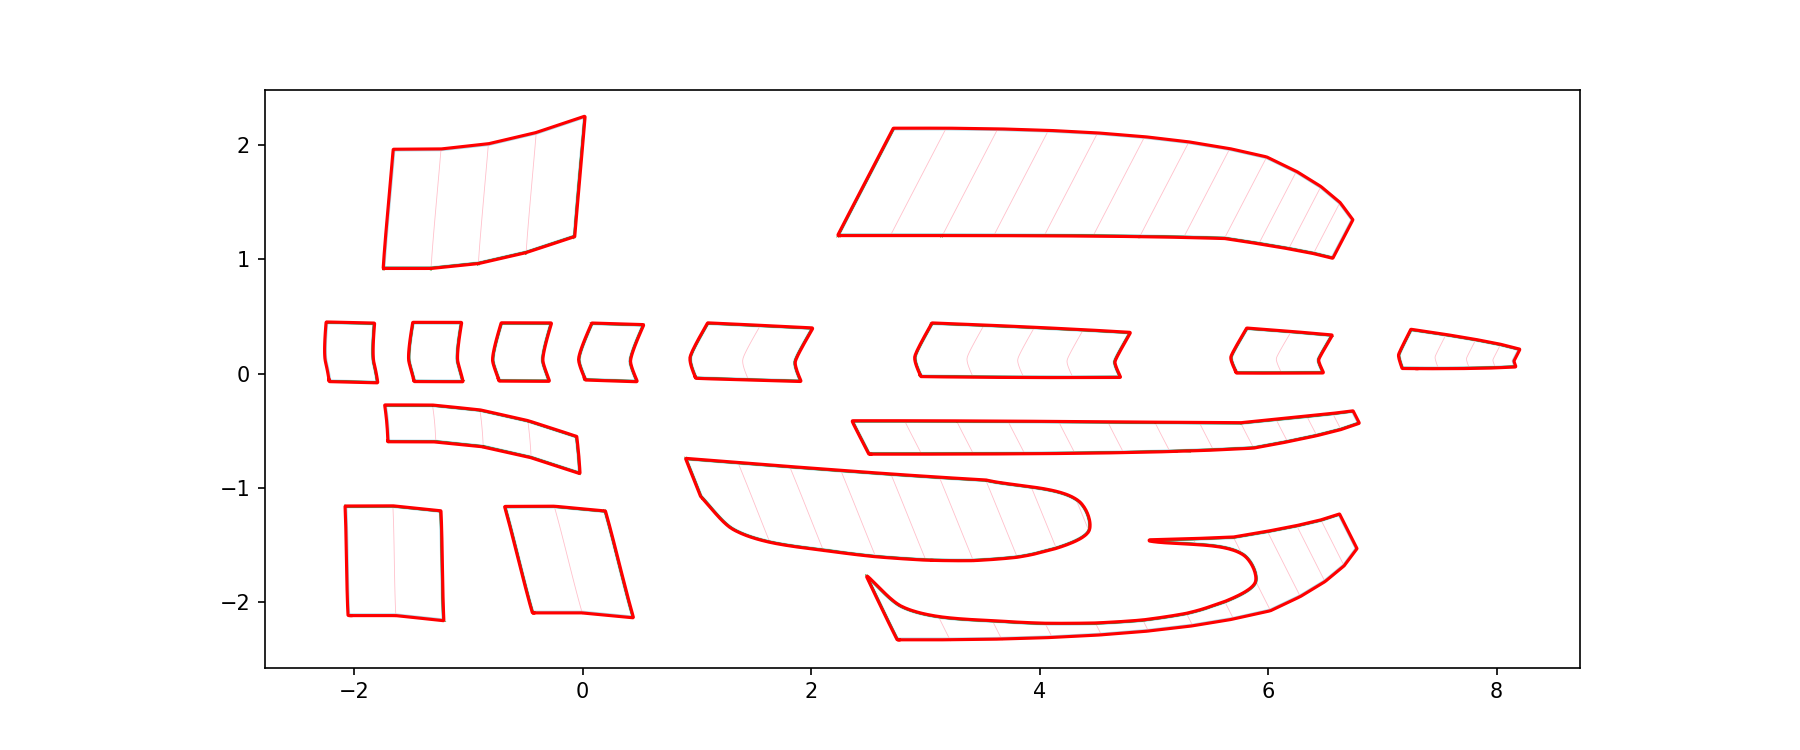

In [11]:
# 
# projecting UV shapes into flattened area where cell is complete
# 

%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection

from wingflatten_barmeshfuncs import sliceupatnones
from wingflatten_barmeshfuncs import projectspbarmeshF

plt.figure(figsize=(12,5))
bFlattenedPatches = True

for I in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[I]
    bm, xpart, ypart = surfacemesh["barmeshoffset"], surfacemesh["xpart"], surfacemesh["ypart"]

    # uvpts is original parametric space, pts is 3D space, fpts is flattened space, fptsT is rotated and moved flattened piece
    uvpts = surfacemesh["uvpts"]
    fptsT = surfacemesh["fptsT"] if bFlattenedPatches else surfacemesh["uvpts"]

    polyi = surfacemesh["offsetloopI"]
    polyloop = surfacemesh["polyloop"]
    cpolycolumns = surfacemesh["cpolycolumns"]

    if bFlattenedPatches:
        sps = [ fptsT[k]  for k in polyi ]
        plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
        polyloopF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyloop ]
        plt.gca().add_collection(LineCollection(sliceupatnones(polyloopF), color="lightblue"))
        for battonuvline in battonuvlines:
            battonlineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in battonuvline ]
            plt.gca().add_collection(LineCollection(sliceupatnones(battonlineF), color="pink", linewidth=0.4))

    else:
        sps = [ uvpts[k]  for k in polyi ]
        plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
        plt.plot([sp[0] for sp in polyloop], [sp[1] for sp in polyloop], color="lightblue")
        if I == 0:
            for battonuvline in battonuvlines:
                plt.plot([sp[0] for sp in battonuvline], [sp[1] for sp in battonuvline], color="pink")
        
    for J in range(len(surfacemeshes)):
        if J == I:
            continue
        surfacemeshJ = surfacemeshes[J]
        polyiJ = surfacemeshJ["offsetloopI"]
        fptsJ = surfacemeshJ["uvpts"]
        spsJ = [ fptsJ[i]  for i in polyiJ ]
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        plt.gca().add_collection(LineCollection(sliceupatnones(spsJF), color="green", linewidth=0.3))

        
plt.gca().autoscale()
plt.gca().set_aspect("equal")


In [12]:
#
# Measure the projected shared seams between given pairs of patches
#

from wingflatten_barmeshfuncs import subloopsequence

def projectcurvelength(polyline, surfacemesh):
    xpart = surfacemesh["xpart"]
    uvpts = surfacemesh["uvpts"]
    fptsT = surfacemesh["fptsT"]
    cpolycolumns = surfacemesh["cpolycolumns"]
    polylineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyline ]
    return sum((p1-p2).Len()  for p1, p2 in zip(polylineF, polylineF[1:]))

def real3dcurvelength(polyline):
    polylineR = [ parapolygraph.wingshape.seval(p)  for p in polyline ] 
    return sum((p1-p2).Len()  for p1, p2 in zip(polylineR, polylineR[1:]))


def sharededgelengths(poly1, poly2):
    surfacemesh1 = surfacemeshesdict[poly1]
    surfacemesh2 = surfacemeshesdict[poly2]

    polynodesshared = subloopsequence(surfacemesh1["polynodes"], set(surfacemesh2["polynodes"]))
    polylineshared = parapolygraph.splinedpolypoints(polynodesshared[0], bclosed=False)

    reallength = real3dcurvelength(polylineshared)
    poly1projlength = projectcurvelength(polylineshared, surfacemesh1)
    poly2projlength = projectcurvelength(polylineshared, surfacemesh2)

    return (poly1, poly2, reallength, poly1projlength, poly2projlength)


print("patch1\tpatch2\treal\tflat1\tflat2")
patchpairs = [ ("US1", "US2"), ("LEI1", "LEI2"), ("LEI5", "LEI6"), 
               ("TSM1", "TSM2"), ("TSF2", "TSM3"), 
               ("TSM2", "TSR"), ("TSM2", "TSM3") ]
for poly1, poly2 in patchpairs:
    print("%s\t%s\t%.4f\t%.4f\t%.4f" % sharededgelengths(poly1, poly2))
    

patch1	patch2	real	flat1	flat2
US1	US2	1.0456	1.0455	1.0456
LEI1	LEI2	0.5161	0.5158	0.5159
LEI5	LEI6	0.5047	0.5039	0.5039
TSM1	TSM2	0.9512	0.9512	0.9512
TSF2	TSM3	2.6291	2.6291	2.6290
TSM2	TSR	0.6047	0.6047	0.6046
TSM2	TSM3	0.3504	0.3504	0.3504


In [13]:
#
# Now output to the dxf file
#

import ezdxf, os

AAMA_CUT = "1"
AAMA_DRAW = "8"
AAMA_INTCUT = "11"

outputfilename = "test.dxf"
dxfversion = "R12"
breflY = False

def convvectoez(pt, breflY):
    return ezdxf.math.Vec3(pt[0]*1000, -pt[1]*1000 if breflY else pt[1]*1000, 0.0)

blockbasename = os.path.splitext(os.path.split(outputfilename)[1])[0]
doc = ezdxf.new(dxfversion)
aamacutlayer = doc.layers.new("1", {"color":1})
aamadrawlayer = doc.layers.new("8", {"color":4})
aamaintcutlayer = doc.layers.new("11", {"color":3})
patchshapelayer = doc.layers.new("21", {"color":21})

for I in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[I]
    fpts = surfacemesh["fptsT"]
    blockname = blockbasename+"-"+surfacemesh["patchname"]
    polyi = surfacemesh["offsetloopI"]
    polyloop = surfacemesh["polyloop"]
    cpolycolumns = surfacemesh["cpolycolumns"]
    xpart = surfacemesh["xpart"]
    contour = [ fpts[i]  for i in polyi ]
    ptsseq = [ convvectoez(p, breflY)  for p in contour ]
    block = doc.blocks.new(name=blockname)
    contourcentre = ezdxf.math.Vec3((min(p.x  for p in ptsseq) + max(p.x  for p in ptsseq))/2, 
                                    (min(p.y  for p in ptsseq) + max(p.y  for p in ptsseq))/2, 0)
    cptsseq = [ pt - contourcentre  for pt in ptsseq ]
    block.add_polyline2d(cptsseq, dxfattribs={ "layer":aamacutlayer.dxf.name })
    battonlines = [ ]
    for battonuvline in battonuvlines:
        battonlineF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in battonuvline ]
        battonlines.extend(sliceupatnones(battonlineF))
    for battonline in battonlines:
        block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in battonline], dxfattribs={ "layer":aamadrawlayer.dxf.name })

    polyloopF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in polyloop ]
    block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in polyloopF], dxfattribs={ "layer":patchshapelayer.dxf.name })
        
    for J in range(len(surfacemeshes)):
        if J == I:
            continue
        surfacemeshJ = surfacemeshes[J]
        polyiJ = surfacemeshJ["offsetloopI"]
        fptsJ = surfacemeshJ["uvpts"]
        spsJ = [ fptsJ[i]  for i in polyiJ ]
        spsJF = [ projectspbarmeshF(P2(*sp), xpart, cpolycolumns, uspacing, vspacing)  for sp in spsJ ]
        spsJFs = sliceupatnones(spsJF)
        for lspsJFs in spsJFs:
            block.add_polyline2d([convvectoez(p, breflY) - contourcentre  for p in lspsJFs], dxfattribs={ "layer":aamadrawlayer.dxf.name })
        
    msp = doc.modelspace()
    dxfattribs = {'rotation': 0, 'linetype':'BYLAYER' }
    k = msp.add_blockref(blockname, contourcentre, dxfattribs=dxfattribs)

doc.set_modelspace_vport(height=2300, center=(1800, 900))
doc.saveas(outputfilename)


<IPython.core.display.Javascript object>


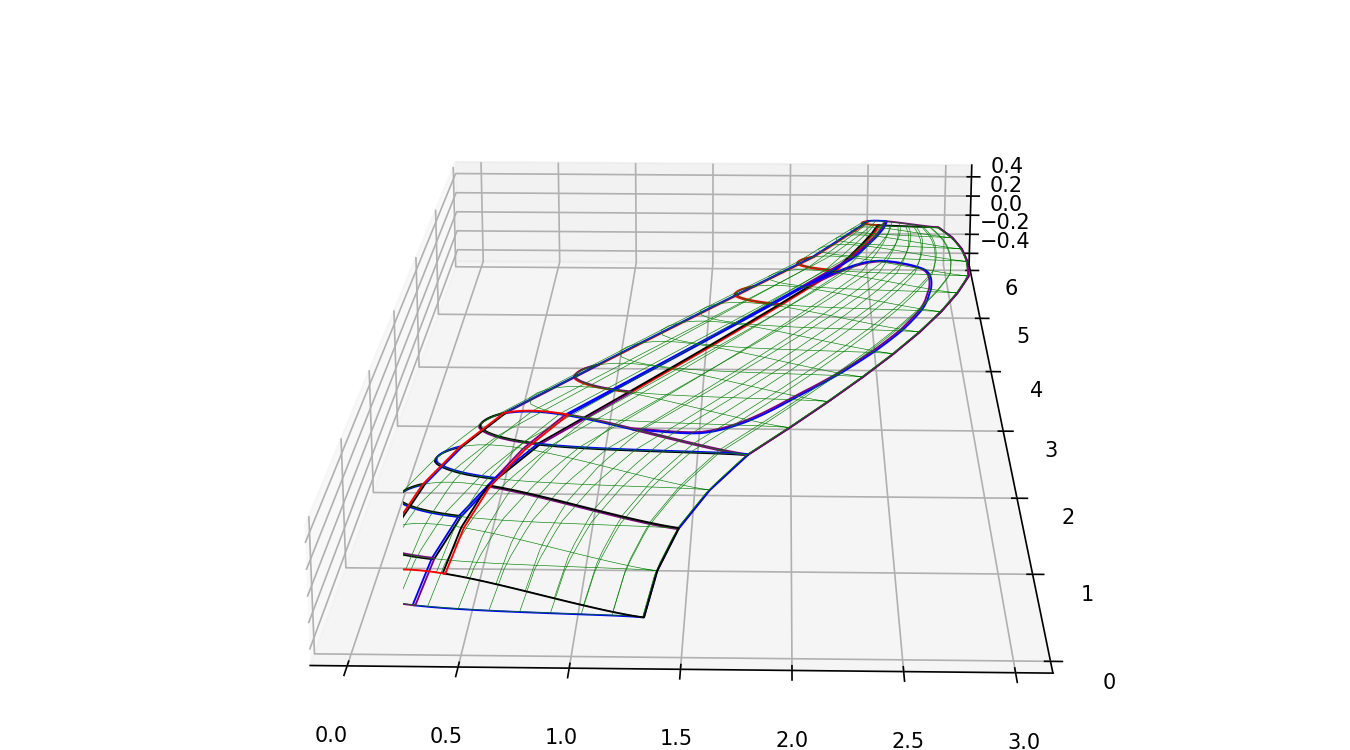

(0.0, 6.0)

In [19]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)